In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import joblib  # For saving and loading the model
import random

In [4]:
# Set random seed for reproducibility
np.random.seed(42)

In [8]:
# 1. Data Collection: Simulate dummy sensor data
def simulate_sensor_data(num_samples=1000):
    # Simulate acoustic noise levels (dB) ranging from 60 to 100
    noise_levels = np.random.uniform(60, 100, num_samples)
    
    # Simulate brake pad thickness (mm) ranging from 5 to 15
    brake_thickness = np.random.uniform(5, 15, num_samples)
    
    # Simulate temperature (°C) ranging from 20 to 100
    temperature = np.random.uniform(20, 100, num_samples)
    
    # Create a DataFrame to hold the data
    data = pd.DataFrame({
        'Noise': noise_levels,
        'Thickness': brake_thickness,
        'Temperature': temperature
    })
    
    return data

In [20]:

# Generate the sensor data
sensor_data = simulate_sensor_data()
print(sensor_data.head())

       Noise  Thickness  Temperature
0  86.908120  10.719959    51.490842
1  91.867256  13.054323    57.874853
2  70.018716  12.601609    88.363791
3  84.994964   6.538999    47.200351
4  82.869839   6.492495    89.571975


In [22]:
# 2. Data Cleaning
def clean_data(data):
    # Handle missing values: Fill missing values with the mean of the column
    data.fillna(data.mean(), inplace=True)

    # Handle outliers: Remove data points that are more than 3 standard deviations from the mean
    for column in data.columns:
        mean = data[column].mean()
        std_dev = data[column].std()
        data = data[(data[column] >= (mean - 3 * std_dev)) & (data[column] <= (mean + 3 * std_dev))]
    
    return data

In [24]:
# Clean the sensor data
cleaned_data = clean_data(sensor_data.copy())
print(cleaned_data.describe())

             Noise    Thickness  Temperature
count  1000.000000  1000.000000  1000.000000
mean     79.615002     9.941053    59.877159
std      11.459574     2.868099    23.135585
min      60.026136     5.000307    20.494706
25%      69.676031     7.449740    39.950400
50%      79.371171     9.945981    59.232225
75%      89.501632    12.399935    79.188142
max      99.982308    14.977494    99.948024


In [26]:
# 3. Data Preprocessing
def preprocess_data(data):
    # Normalize the data using StandardScaler
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data)

    # Convert back to DataFrame
    normalized_df = pd.DataFrame(normalized_data, columns=data.columns)

    # Split data into training and testing sets (80-20 split)
    X = normalized_df.drop('Thickness', axis=1)  # Features
    y = normalized_df['Thickness']  # Target variable

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test, scaler

In [28]:
# Preprocess the cleaned data
X_train, X_test, y_train, y_test, scaler = preprocess_data(cleaned_data)

# 4. Random Forest Model
def train_random_forest(X_train, y_train):
    # Initialize Random Forest model with hyperparameter tuning using Grid Search
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    
    rf_model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    return grid_search.best_estimator_

In [30]:
# Train the model
rf_model = train_random_forest(X_train, y_train)

In [31]:
# Define a critical limit for brake pad wear
critical_limit = 10  # mm

In [32]:
# Predict and generate alerts
def generate_alerts(model, X_test):
    predictions = model.predict(X_test)
    alerts = predictions < critical_limit
    return predictions, alerts

In [36]:
# Generate predictions and alerts
predictions, alerts = generate_alerts(rf_model, X_test)


In [38]:
# Output alerts
for i, alert in enumerate(alerts):
    if alert:
        print(f"Alert: Predicted brake pad thickness is {predictions[i]:.2f} mm - Maintenance required!")


Alert: Predicted brake pad thickness is -0.24 mm - Maintenance required!
Alert: Predicted brake pad thickness is 0.02 mm - Maintenance required!
Alert: Predicted brake pad thickness is -0.33 mm - Maintenance required!
Alert: Predicted brake pad thickness is 0.14 mm - Maintenance required!
Alert: Predicted brake pad thickness is -0.22 mm - Maintenance required!
Alert: Predicted brake pad thickness is 0.04 mm - Maintenance required!
Alert: Predicted brake pad thickness is -0.45 mm - Maintenance required!
Alert: Predicted brake pad thickness is -0.00 mm - Maintenance required!
Alert: Predicted brake pad thickness is -0.20 mm - Maintenance required!
Alert: Predicted brake pad thickness is -0.36 mm - Maintenance required!
Alert: Predicted brake pad thickness is -0.30 mm - Maintenance required!
Alert: Predicted brake pad thickness is -0.03 mm - Maintenance required!
Alert: Predicted brake pad thickness is -0.26 mm - Maintenance required!
Alert: Predicted brake pad thickness is -0.15 mm - Mai

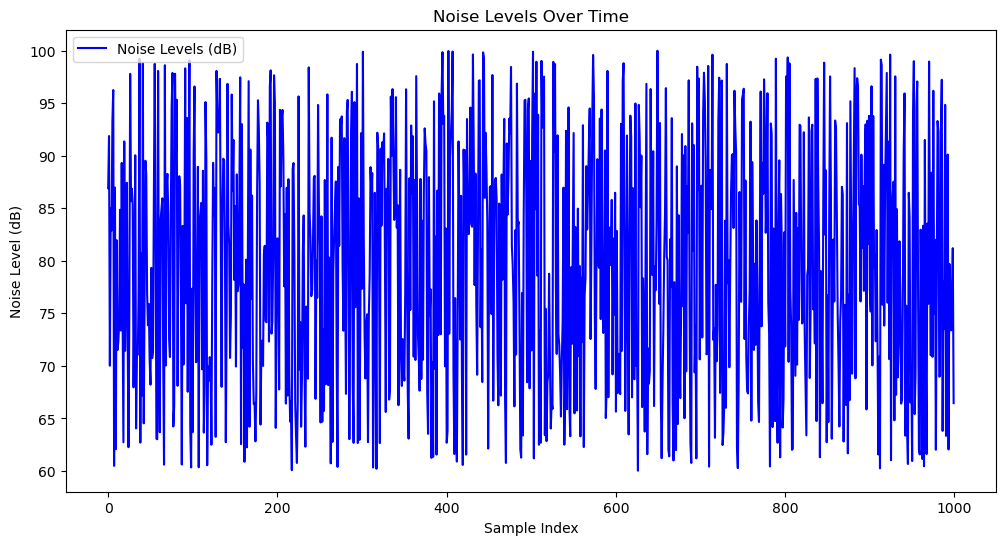

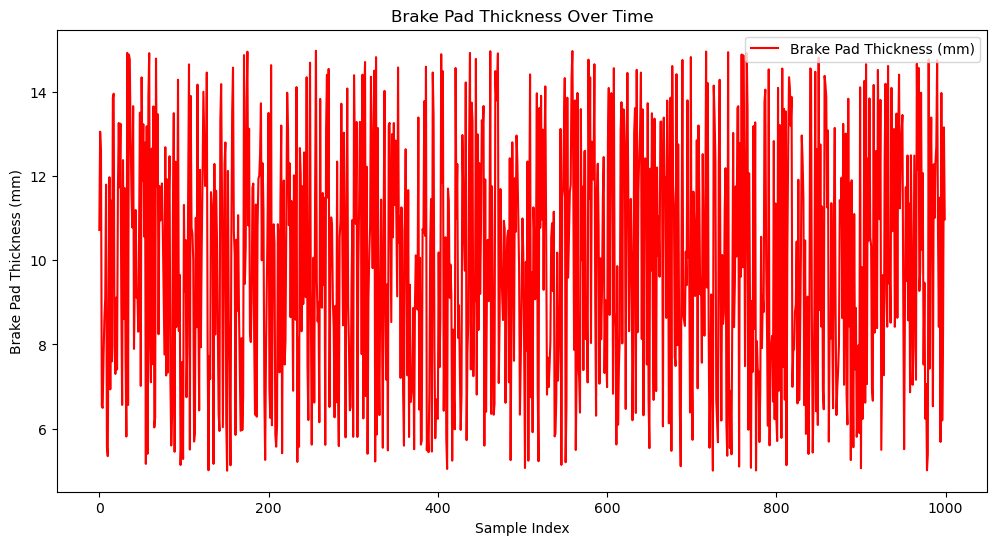

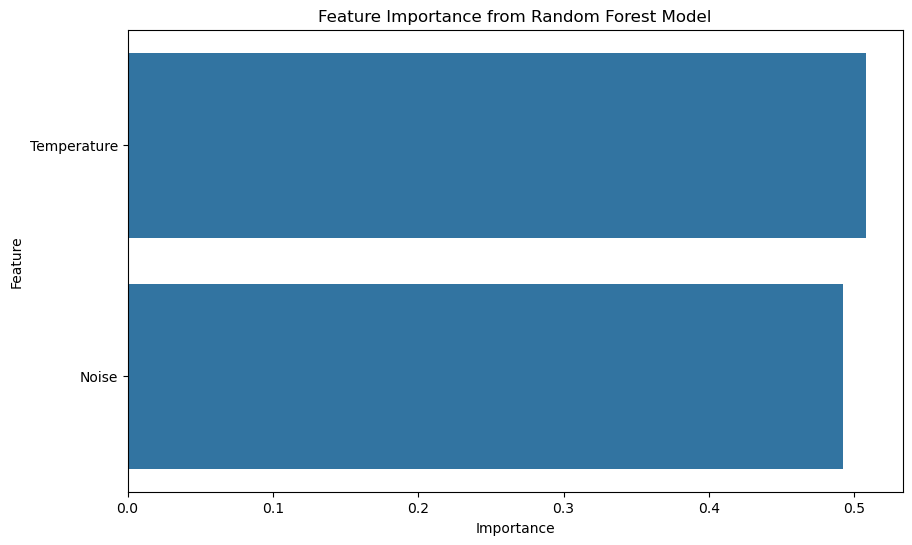

In [48]:
# 5. Data Visualization
def visualize_data(data, model, X_train, X_test):
    # Plot noise levels over time
    plt.figure(figsize=(12, 6))
    plt.plot(data['Noise'], label='Noise Levels (dB)', color='blue')
    plt.title('Noise Levels Over Time')
    plt.xlabel('Sample Index')
    plt.ylabel('Noise Level (dB)')
    plt.legend()
    plt.show()

    # Plot brake pad thickness over time
    plt.figure(figsize=(12, 6))
    plt.plot(data['Thickness'], label='Brake Pad Thickness (mm)', color='red')
    plt.title('Brake Pad Thickness Over Time')
    plt.xlabel('Sample Index')
    plt.ylabel('Brake Pad Thickness (mm)')
    plt.legend()
    plt.show()

    # Feature importance from the Random Forest model
    feature_importances = model.feature_importances_
    features = X_train.columns

    # Create a DataFrame for feature importances
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance from Random Forest Model')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

# Call the visualization function
visualize_data(cleaned_data, rf_model, X_train, X_test)